## About Dataset

The loan approval dataset is a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as cibil score, income, employment status, loan term, loan amount, assets value, and loan status. This dataset is commonly used in machine learning and data analysis to develop models and algorithms that predict the likelihood of loan approval based on the given features.


#### About columns (Information provided by the owner)

- `loan_id`
- `no_of_dependents`: The number of people financially dependent on the loan applicant.
- `education`: Education of the Applicant (Graduate/Not Graduate)
- `self_employed`: Employment Status of the Applicant
- `income_annum`: Annual Income of the Applicant
- `loan_amount`: The amount of loan requested.
- `loan_term`: The duration for which the loan is taken, expressed in years.
- `cibil_score`: Credit Score
- `residential_assets_value`: (נכסי מגורים)
- `commercial_assets_value`: real estate properties that are used for business activities. Unlike residential properties, which are used for living purposes, commercial properties are intended for commerce(מסחר).
- `luxury_assets_value`: The value of luxury items (like cars, jewelry, etc.) owned by the applicant. For example: Office Buildings.
- `bank_asset_value`: The total value of assets or money the applicant has in the bank.
- `loan_status`: Loan Approval Status (Approved/Rejected)


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV
from tabulate import tabulate
import numpy as np
from metrics import (
    calculate_metrics,
    metrics_to_tabular_string,
    find_best_threshold_for_mcc,
)
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os

input_dir = "./kaggle/input"
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


In [3]:
random_state = 42

loan_original = pd.read_csv(
    os.path.join(
        input_dir, "loan-approval-prediction-dataset/loan_approval_dataset.csv"
    )
)
# columns have weird spaces in names:
loan_original.columns = loan_original.columns.str.replace(" ", "")
loan_original[loan_original["loan_id"].duplicated(keep=False) == True].sort_values(
    ["loan_id"]
)
# remove the loan_id column
loan_ds = loan_original.drop(["loan_id"], axis=1)
# replace all spaces in loan_status and education and self_employed columns to
loan_ds["loan_status"] = loan_ds["loan_status"].str.replace(" ", "")
loan_ds["education"] = loan_ds["education"].str.replace(" ", "")
loan_ds["self_employed"] = loan_ds["self_employed"].str.replace(" ", "")


GRADUATE_STRING = loan_ds["education"].unique()[0]
NOT_GRADUATE_STRING = loan_ds["education"].unique()[1]

# make education column binary
loan_ds["education"] = loan_ds["education"].apply(
    lambda x: 1 if x == GRADUATE_STRING else 0
)

APPROVED_STRING = loan_ds["loan_status"].unique()[0]
REJECTED_STRING = loan_ds["loan_status"].unique()[1]

# make loan_status column binary
loan_ds["loan_status"] = loan_ds["loan_status"].apply(
    lambda x: 1 if x == APPROVED_STRING else 0
)

YES_STRING = loan_ds["self_employed"].unique()[1]
NO_STRING = loan_ds["self_employed"].unique()[0]

# make self_employed column binary
loan_ds["self_employed"] = loan_ds["self_employed"].apply(
    lambda x: 1 if x == YES_STRING else 0
)

print(loan_ds.columns)

print(
    f"{GRADUATE_STRING=}, {NOT_GRADUATE_STRING=}, {APPROVED_STRING=}, {REJECTED_STRING=}, {YES_STRING=}, {NO_STRING=}"
)

loan_ds.head()

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')
GRADUATE_STRING='Graduate', NOT_GRADUATE_STRING='NotGraduate', APPROVED_STRING='Approved', REJECTED_STRING='Rejected', YES_STRING='Yes', NO_STRING='No'


no_of_dependents  education  self_employed  income_annum  loan_amount  \
0                 2          1              0       9600000     29900000   
1                 0          0              1       4100000     12200000   
2                 3          1              0       9100000     29700000   
3                 3          1              0       8200000     30700000   
4                 5          0              1       9800000     24200000   

   loan_term  cibil_score  residential_assets_value  commercial_assets_value  \
0         12          778                   2400000                 17600000   
1          8          417                   2700000                  2200000   
2         20          506                   7100000                  4500000   
3          8          467                  18200000                  3300000   
4         20          382                  12400000                  8200000   

   luxury_assets_value  bank_asset_value  loan_status  
0             22700000           8000000            1  
1              8800000           3300000            0  
2             33300000          12800000            0  
3             23300000           7900000            0  
4             29400000           5000000            0

In [4]:
loan_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [5]:
loan_original.describe(include="all")

loan_id  no_of_dependents  education self_employed  income_annum  \
count   4269.000000       4269.000000       4269          4269  4.269000e+03   
unique          NaN               NaN          2             2           NaN   
top             NaN               NaN   Graduate           Yes           NaN   
freq            NaN               NaN       2144          2150           NaN   
mean    2135.000000          2.498712        NaN           NaN  5.059124e+06   
std     1232.498479          1.695910        NaN           NaN  2.806840e+06   
min        1.000000          0.000000        NaN           NaN  2.000000e+05   
25%     1068.000000          1.000000        NaN           NaN  2.700000e+06   
50%     2135.000000          3.000000        NaN           NaN  5.100000e+06   
75%     3202.000000          4.000000        NaN           NaN  7.500000e+06   
max     4269.000000          5.000000        NaN           NaN  9.900000e+06   

         loan_amount    loan_term  cibil_score  residential_assets_value  \
count   4.269000e+03  4269.000000  4269.000000              4.269000e+03   
unique           NaN          NaN          NaN                       NaN   
top              NaN          NaN          NaN                       NaN   
freq             NaN          NaN          NaN                       NaN   
mean    1.513345e+07    10.900445   599.936051              7.472617e+06   
std     9.043363e+06     5.709187   172.430401              6.503637e+06   
min     3.000000e+05     2.000000   300.000000             -1.000000e+05   
25%     7.700000e+06     6.000000   453.000000              2.200000e+06   
50%     1.450000e+07    10.000000   600.000000              5.600000e+06   
75%     2.150000e+07    16.000000   748.000000              1.130000e+07   
max     3.950000e+07    20.000000   900.000000              2.910000e+07   

        commercial_assets_value  luxury_assets_value  bank_asset_value  \
count              4.269000e+03         4.269000e+03      4.269000e+03   
unique                      NaN                  NaN               NaN   
top                         NaN                  NaN               NaN   
freq                        NaN                  NaN               NaN   
mean               4.973155e+06         1.512631e+07      4.976692e+06   
std                4.388966e+06         9.103754e+06      3.250185e+06   
min                0.000000e+00         3.000000e+05      0.000000e+00   
25%                1.300000e+06         7.500000e+06      2.300000e+06   
50%                3.700000e+06         1.460000e+07      4.600000e+06   
75%                7.600000e+06         2.170000e+07      7.100000e+06   
max                1.940000e+07         3.920000e+07      1.470000e+07   

       loan_status  
count         4269  
unique           2  
top       Approved  
freq          2656  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN

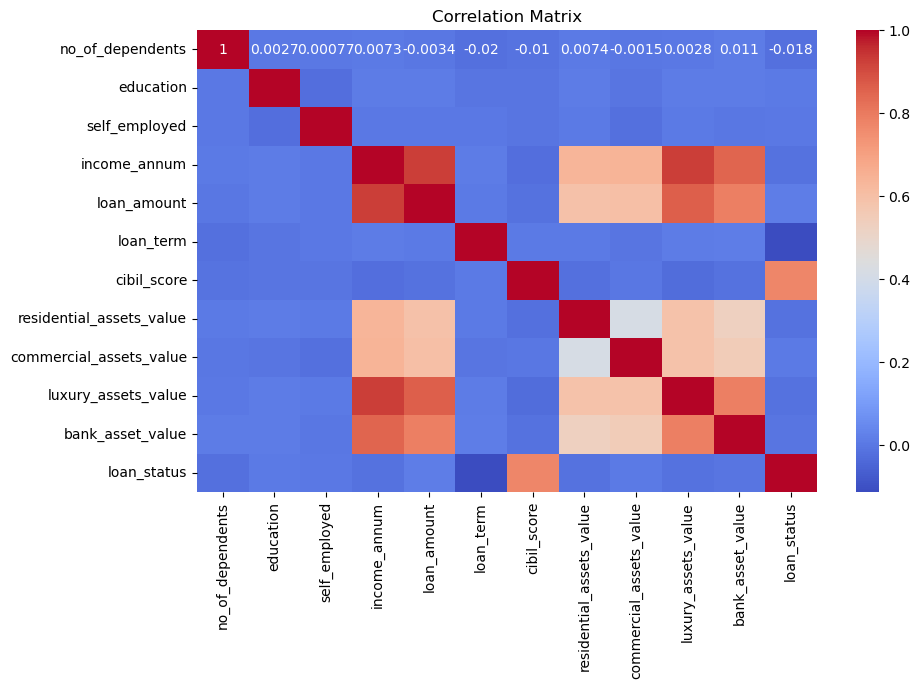

In [6]:
# corr and sns.heatmap
corr = loan_ds.corr()
plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

<Figure size 2000x2000 with 0 Axes>

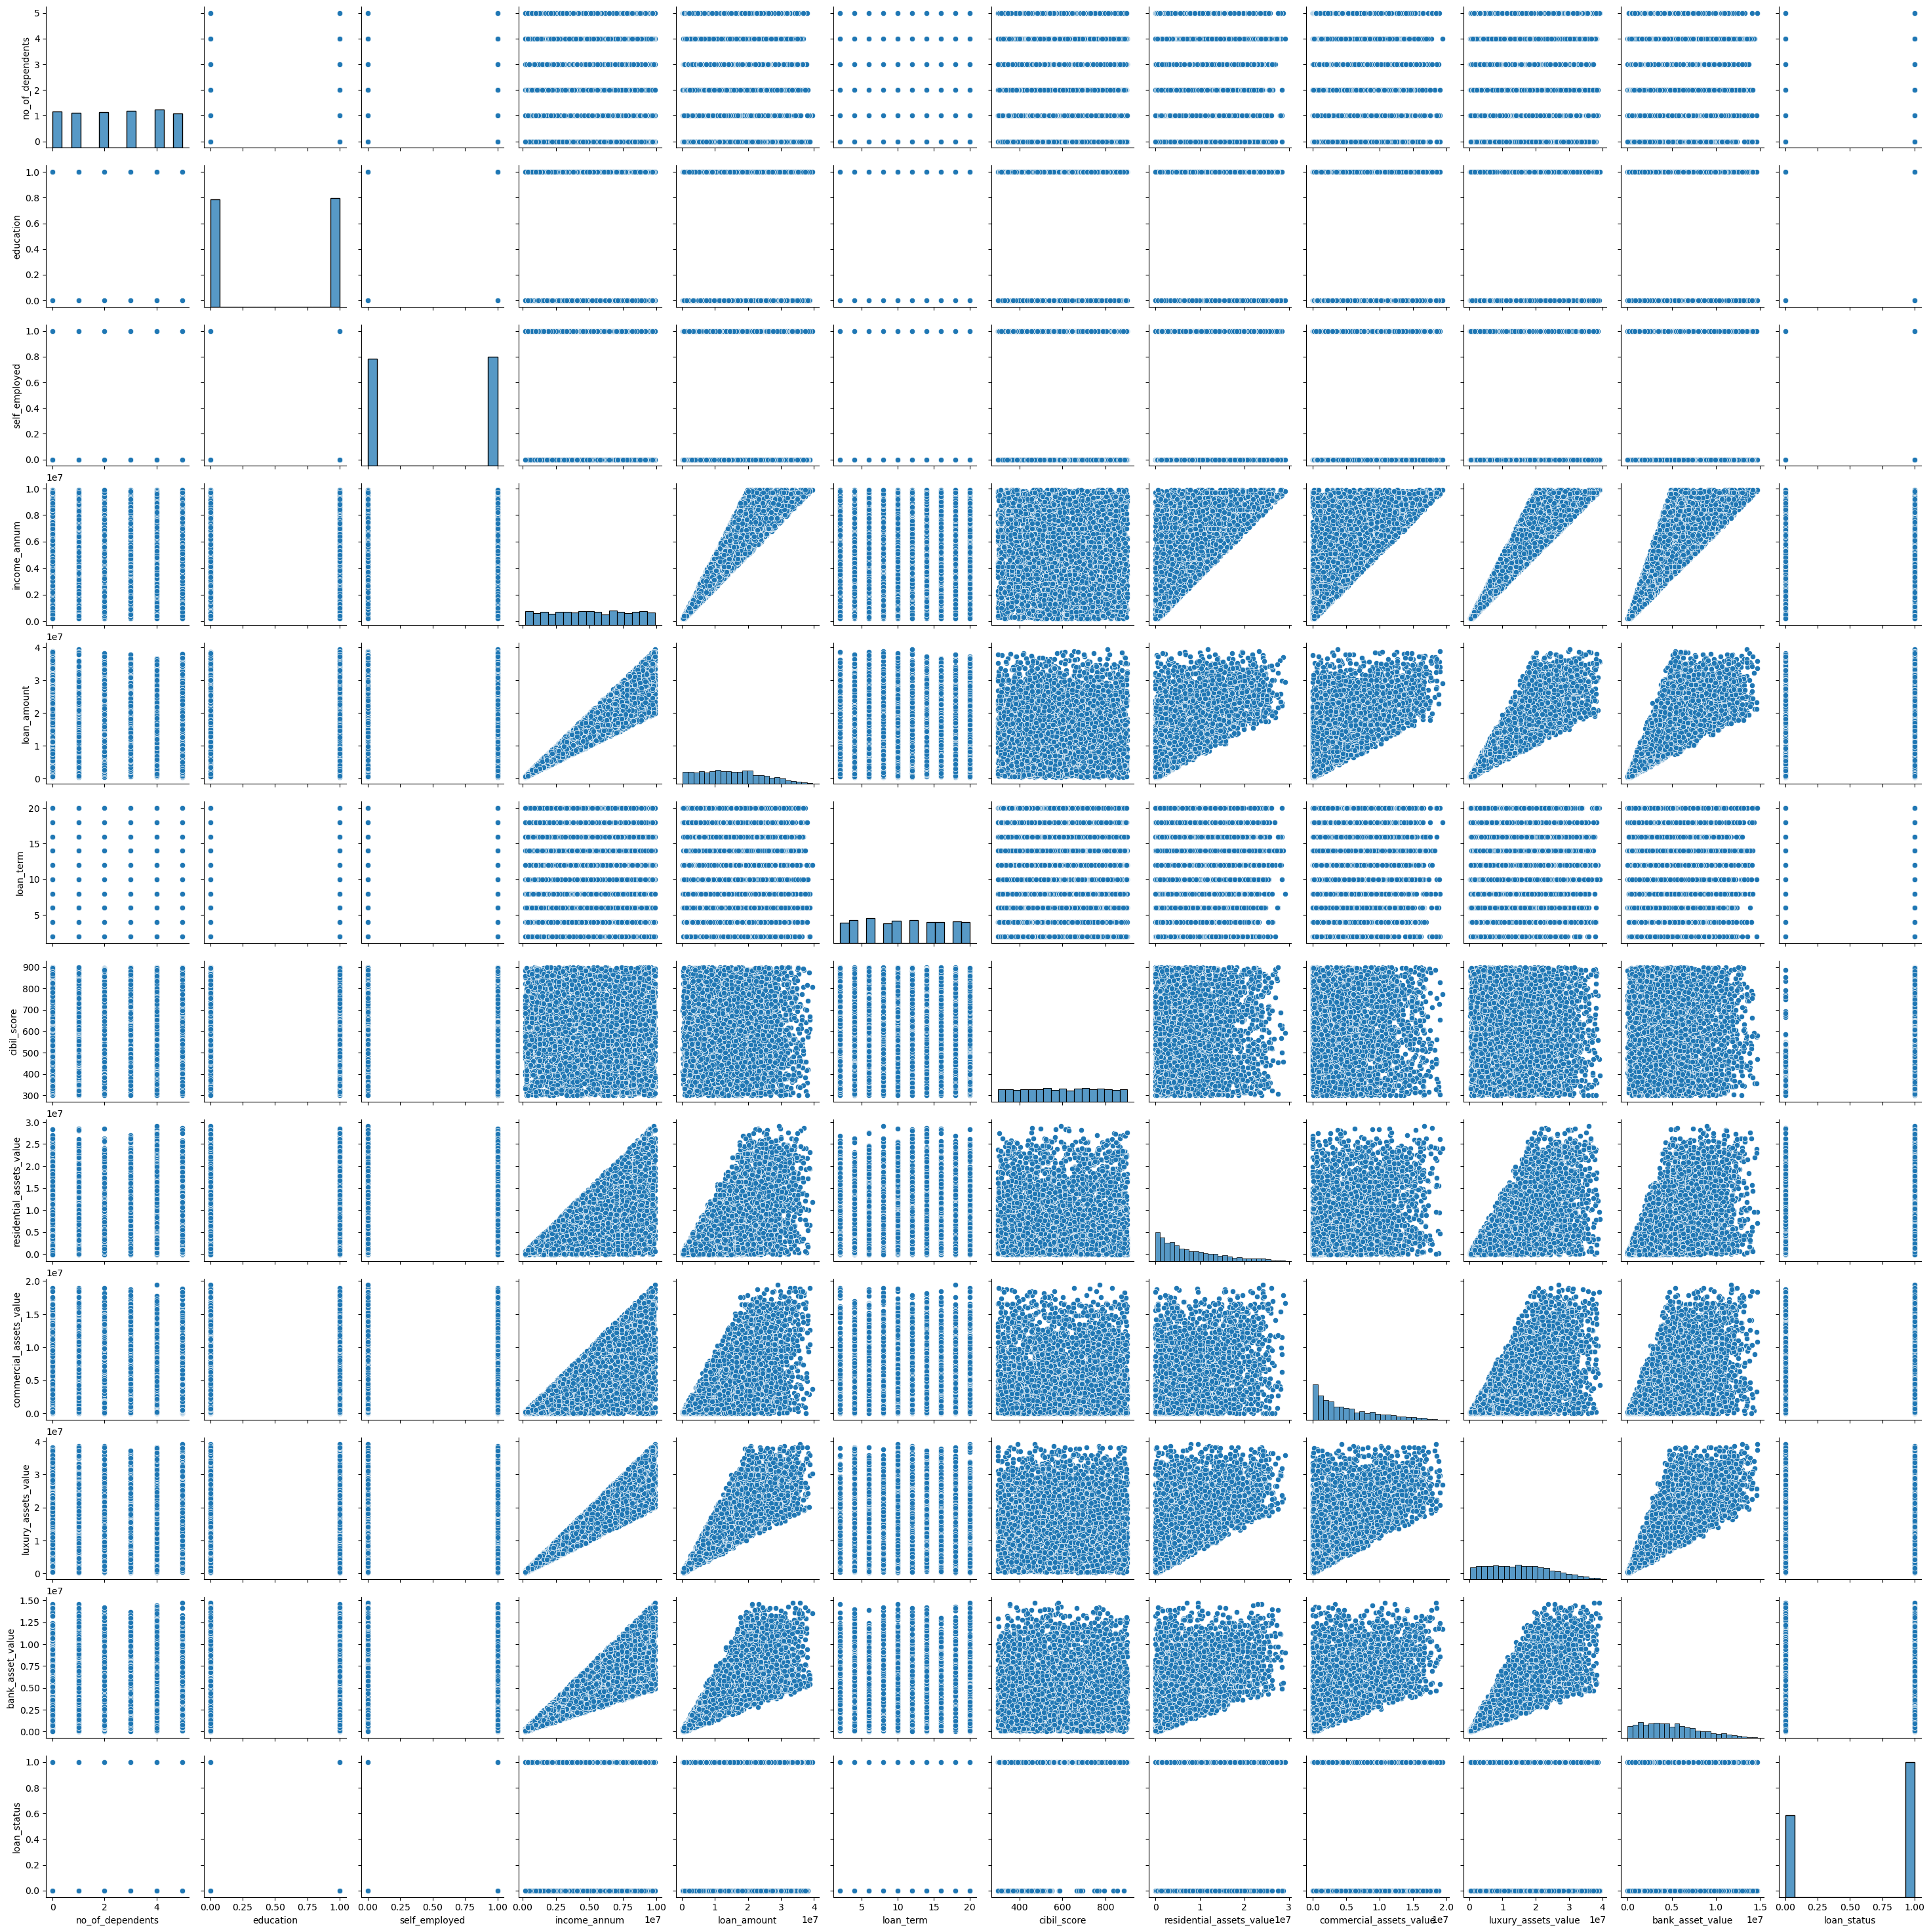

In [7]:
# plot the sns.pairplot(loan_ds)
plt.figure(figsize=(20, 20))
sns.pairplot(loan_ds)
plt.show()

We can see high correlation between luxury assets value and annual income,
wich makes sense. People that have higher income tend to have more luxury assets
like special cars etc.


By the data cleaning scans, we have confirmed:

1. There is no null value and duplicated value in this dataset.
1. `no_of_dependents`, `education`, `self_employed` and `loan_status` are categorical columns.
1. There are a total 4269 rows in this dataset, with 13 columns (features).
1. There are 2656 data with an approved `loan_status`, which is about 62.2% compared to the "rejected" group. The dataset is slightly imbalanced but it is acceptable and we don't need to rebalance it.
1. Other columns are numerical.


In [8]:
loan_ds

no_of_dependents  education  self_employed  income_annum  loan_amount  \
0                    2          1              0       9600000     29900000   
1                    0          0              1       4100000     12200000   
2                    3          1              0       9100000     29700000   
3                    3          1              0       8200000     30700000   
4                    5          0              1       9800000     24200000   
...                ...        ...            ...           ...          ...   
4264                 5          1              1       1000000      2300000   
4265                 0          0              1       3300000     11300000   
4266                 2          0              0       6500000     23900000   
4267                 1          0              0       4100000     12800000   
4268                 1          1              0       9200000     29700000   

      loan_term  cibil_score  residential_assets_value  \
0            12          778                   2400000   
1             8          417                   2700000   
2            20          506                   7100000   
3             8          467                  18200000   
4            20          382                  12400000   
...         ...          ...                       ...   
4264         12          317                   2800000   
4265         20          559                   4200000   
4266         18          457                   1200000   
4267          8          780                   8200000   
4268         10          607                  17800000   

      commercial_assets_value  luxury_assets_value  bank_asset_value  \
0                    17600000             22700000           8000000   
1                     2200000              8800000           3300000   
2                     4500000             33300000          12800000   
3                     3300000             23300000           7900000   
4                     8200000             29400000           5000000   
...                       ...                  ...               ...   
4264                   500000              3300000            800000   
4265                  2900000             11000000           1900000   
4266                 12400000             18100000           7300000   
4267                   700000             14100000           5800000   
4268                 11800000             35700000          12000000   

      loan_status  
0               1  
1               0  
2               0  
3               0  
4               0  
...           ...  
4264            0  
4265            1  
4266            0  
4267            1  
4268            1  

[4269 rows x 12 columns]

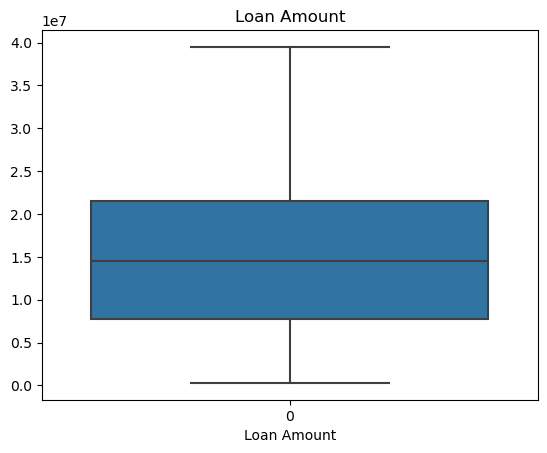

In [9]:
# no outliers?

sns.boxplot(loan_ds["loan_amount"])
plt.title("Loan Amount")
plt.xlabel("Loan Amount")
plt.show()

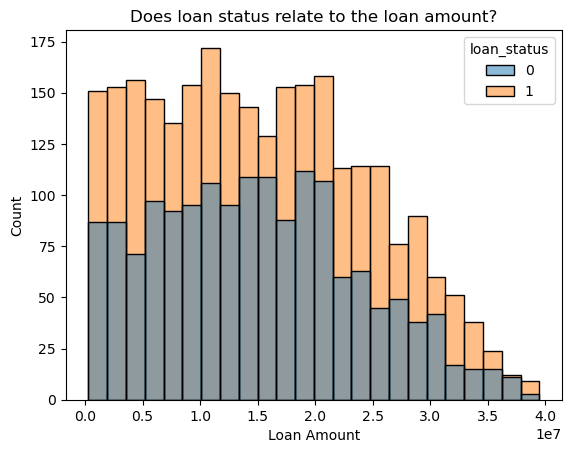

In [10]:
sns.histplot(loan_ds, x="loan_amount", hue="loan_status")
plt.title("Does loan status relate to the loan amount?")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

We can see that loan amount does not affects the loan status.


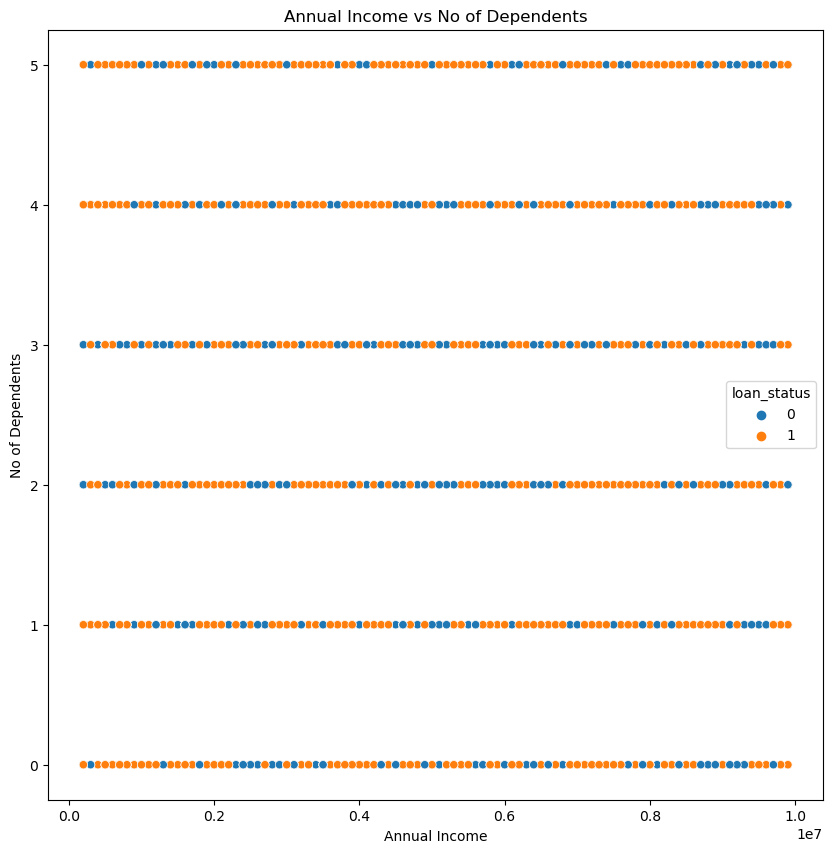

In [11]:
# show graph of annual income in x, loan status in red(Rejected) and green(accepted)
# and y will be no_of_dependents
plt.figure(figsize=(10, 10))
sns.scatterplot(data=loan_ds, x="income_annum", y="no_of_dependents", hue="loan_status")
plt.title("Annual Income vs No of Dependents")
plt.xlabel("Annual Income")
plt.ylabel("No of Dependents")
plt.show()

We can see that num of dependents is not very affective in predicting load_status


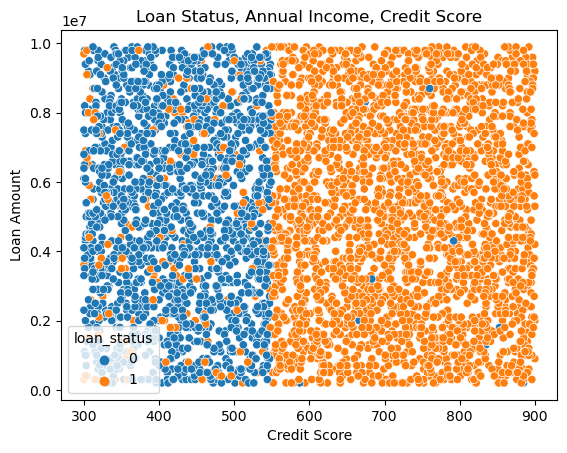

In [12]:
sns.scatterplot(
    x=loan_ds["cibil_score"], y=loan_ds["income_annum"], hue=loan_ds["loan_status"]
)
plt.title("Loan Status, Annual Income, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

- We can see there is some threshold around 540. Let's train linear regression model to predict loan amount based on credit score and annual income to predict the status.


In [13]:
# Let's threshold credit score on 540, all >= 540 will be accepted, all <540 will be rejected(create new pandas with thresh_pred and loan_status),
# then print acc:
def acc_for_column_threshold(
    df,
    feature_column,
    threshold,
    target_column,
    target_value_below_thresh,
    target_value_above_thresh,
):
    # create new df with thresholded column! new! not df
    df_thresh = df.copy()
    # remove all cols except feature_column and target_column
    df_thresh = df_thresh[[feature_column, target_column]]
    # create new column with thresholded values
    df_thresh["thresh_pred"] = df_thresh[feature_column] >= threshold
    # change True/False to target values
    df_thresh["thresh_pred"] = df_thresh["thresh_pred"].replace(
        {True: target_value_above_thresh, False: target_value_below_thresh}
    )
    # calculate accuracy
    acc = accuracy_score(df_thresh[target_column], df_thresh["thresh_pred"])
    return df_thresh, acc


threshold = 540
df_thresh, acc = acc_for_column_threshold(
    loan_ds, "cibil_score", threshold, "loan_status", 0, 1
)
print(f"Accuracy for cibil_score threshold {threshold}: ", acc)
df_thresh

Accuracy for cibil_score threshold 540:  0.9355821035371281


cibil_score  loan_status  thresh_pred
0             778            1            1
1             417            0            0
2             506            0            0
3             467            0            0
4             382            0            0
...           ...          ...          ...
4264          317            0            0
4265          559            1            1
4266          457            0            0
4267          780            1            1
4268          607            1            1

[4269 rows x 3 columns]

In [14]:
approved_num, rejected_num = loan_ds["loan_status"].value_counts()
positive_precent = approved_num / (approved_num + rejected_num)
print("Approved: ", approved_num)
print("Rejected: ", rejected_num)
print("Positive precent: ", positive_precent)

Approved:  2656
Rejected:  1613
Positive precent:  0.622159756383228


Nice, we get 0.93 Accuracy using threshold only, even though the dataset
is not imbalanced, it has 0.62% Approved loans.

If the dataset was imbalanced, for example: 0.9 Approved, this thresholding
was not impressive, as a stupid classifier that always say: Approve!
would get 90% right.


In [15]:
# train LogisticRegression on the dataset
# Prepare the data
X = loan_ds.drop("loan_status", axis=1)
y = loan_ds["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.mean(axis=0), X_train_scaled.std(
    axis=0
), X_train_scaled.shape  # mean should be 0, std should be 1, X_train_scaled

(3415, 11) (854, 11) (3415,) (854,)


(array([-1.00391470e-16, -4.78550012e-17, -5.20163057e-19,  1.37323047e-16,
        -1.04032611e-17,  1.24839134e-16,  8.32260891e-17, -1.61250548e-17,
        -3.43307618e-17,  1.66452178e-17, -1.36282721e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (3415, 11))

In [16]:
def train_and_evaluate_basic_models(
    dataset, target_binary_column, test_size, random_state
):
    X = dataset.drop(target_binary_column, axis=1)
    y = dataset[target_binary_column]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Defining models to train
    models = {
        "Logistic Regression": LogisticRegression(random_state=random_state),
        "Random Forest": RandomForestClassifier(random_state=random_state),
        "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
        "Support Vector Machine": SVC(probability=True, random_state=random_state),
    }

    results = []

    for model_name, model in models.items():
        # Training the model
        model.fit(X_train_scaled, y_train)

        # Getting the probability scores for the positive class
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test_scaled)[:, 1]
        else:  # Use decision function for models like SVM
            y_scores = model.decision_function(X_test_scaled)

        # # Finding the best threshold for Matthews Correlation Coefficient (MCC)
        # We cant use this threshold cause can't look at the test data, we can if validation.
        # best_threshold, _ = find_best_threshold_for_mcc(y_test, y_scores)

        threshold = 0.5
        # Calculating metrics
        metrics = calculate_metrics(y_test, y_scores, threshold)

        # Appending results
        results.append(
            {
                "model_name": model_name,
                "model": model,
                "test_size": test_size,
                "random_state": random_state,
                "metrics": metrics,
            }
        )

    return results


def plot_basic_models_results(results):
    # Setting up the style
    sns.set(style="whitegrid")

    # Plotting Accuracy by Model
    accuracies = [result["metrics"]["accuracy"] for result in results]
    model_names = [result["model_name"] for result in results]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=accuracies, y=model_names, palette="viridis")
    plt.xlabel("Accuracy")
    plt.ylabel("Model")
    plt.title("Accuracy by Model")
    plt.show()

    # Plotting F1 Score by Model
    f1_scores = [result["metrics"]["f1_score"] for result in results]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=f1_scores, y=model_names, palette="magma")
    plt.xlabel("F1 Score")
    plt.ylabel("Model")
    plt.title("F1 Score by Model")
    plt.show()

    # Plotting Confusion Matrices for Each Model
    fig, axes = plt.subplots(nrows=1, ncols=len(results), figsize=(20, 5))
    for i, result in enumerate(results):
        cm = result["metrics"]["confusion_matrix"]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(result["model_name"])
        axes[i].set_xlabel("Predicted labels")
        axes[i].set_ylabel("True labels")
        axes[i].set_xticklabels(["Rejected", "Approved"])
        axes[i].set_yticklabels(["Rejected", "Approved"])

    plt.tight_layout()
    plt.show()


test_size = 0.2
target_binary_column = "loan_status"
basic_models_results = train_and_evaluate_basic_models(
    loan_ds, target_binary_column, test_size, random_state
)

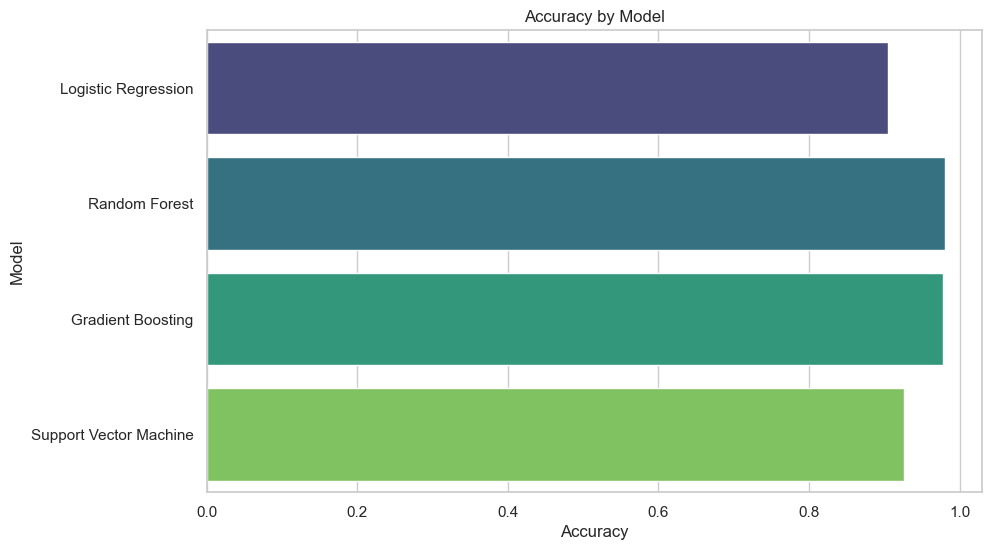

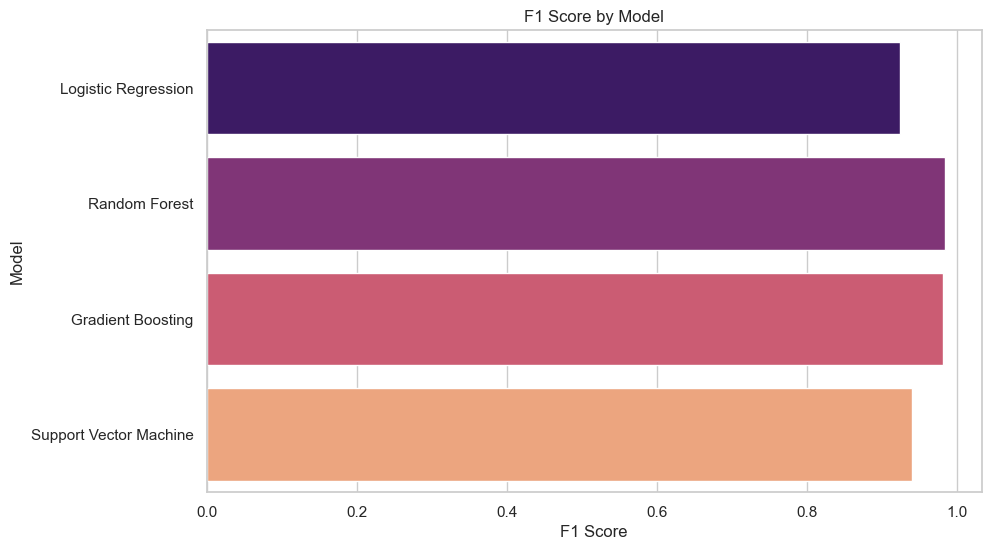

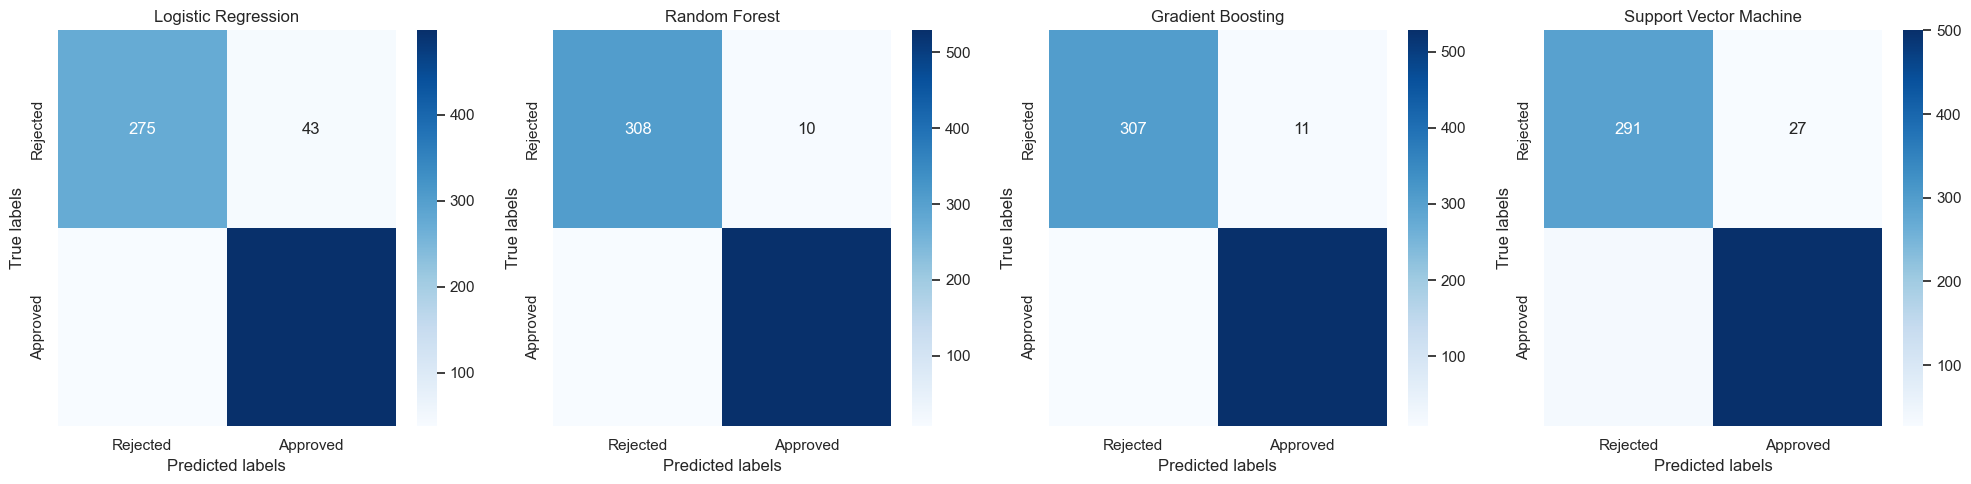

In [17]:
plot_basic_models_results(basic_models_results)

We can see those basic models get good results, but they struggle to mitigate the False Positives...

Let's try using pytorch more complex models:


In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Assuming loan_ds is your DataFrame
X = loan_ds.drop("loan_status", axis=1).values
y = loan_ds["loan_status"].values

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to PyTorch tensors
X_torch_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_torch_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

# # Creating a dataset and dataloader
train_dataset = TensorDataset(X_torch_train_scaled, torch.tensor(y_train))
test_dataset = TensorDataset(X_torch_test_scaled, torch.tensor(y_test))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# supposed to get 0 means and 1 std
X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0), X_train_scaled.shape

(array([-1.14630934e-16, -3.68860628e-16, -4.02476165e-17,  9.93999092e-17,
        -4.03126369e-18,  7.35055420e-17,  6.05339757e-17, -3.51110063e-18,
        -3.66877506e-17,  1.04032611e-18, -1.27265207e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (3415, 11))

In [19]:
class MLPModel(nn.Module):
    def __init__(self, input_size, layers_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layers_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, layer_size))
            else:
                self.layers.append(nn.Linear(layers_sizes[i - 1], layer_size))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Linear(layers_sizes[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)


class Conv1DModel(nn.Module):
    def __init__(self, input_size, output_channels=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, output_channels, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear(
            output_channels * ((input_size + 2 * 1 - kernel_size) // 1 + 1), 64
        )
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size), we need to unsqueeze to (batch_size, 1, input_size) for Conv1D
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [20]:
# create small medium large MLPs
input_size = X_train_scaled.shape[1]
print(input_size)

names_to_models = {
    "Small MLP": MLPModel(input_size, [32, 16]),
    "Medium MLP": MLPModel(input_size, [64, 32, 16]),
    "Large MLP": MLPModel(input_size, [128, 64, 32, 16]),
    "Conv1D": Conv1DModel(input_size),  # Conv1D model
}

11


In [21]:
def train_and_evaluate_pytorch_model(
    model, model_name, train_loader, test_loader, epochs=100, lr=0.001
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc=f"Training {model_name}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Assuming your metrics calculation functions expect numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Use the provided functions to calculate metrics
    # Can use it on validation only
    # best_threshold, _ = find_best_threshold_for_mcc(all_labels, all_outputs)
    threshold = 0.5
    metrics = calculate_metrics(all_labels, all_outputs, threshold)

    return {
        "model": model,
        "model_name": model_name,
        "metrics": metrics,
    }
    # "model_name": model_name,
    # "model": model,
    # "test_size": test_size,
    # "random_state": random_state,
    # "metrics": metrics,

In [22]:
# iterate models and train them
torch_models_results = []
for model_name, model in names_to_models.items():
    print(f"Training {model_name}")
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        model, model_name, train_loader, test_loader, epochs=100, lr=0.001
    )
    torch_models_results.append(result)

Training Small MLP


Training Small MLP: 100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Training Medium MLP


Training Medium MLP: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


Training Large MLP


Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


Training Conv1D


Training Conv1D: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


In [25]:
torch_models_results

[{'model': MLPModel(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=16, out_features=1, bias=True)
    )
  ),
  'model_name': 'Small MLP',
  'metrics': {'threshold_used': 0.5,
   'auc': 0.9964094621233456,
   'accuracy': 0.968384074941452,
   'f1_score': 0.9747427502338634,
   'confusion_matrix': array([[306,  12],
          [ 15, 521]]),
   'mcc': 0.9325163536479512,
   'classification_report': {'0': {'precision': 0.9532710280373832,
     'recall': 0.9622641509433962,
     'f1-score': 0.9577464788732395,
     'support': 318.0},
    '1': {'precision': 0.9774859287054409,
     'recall': 0.9720149253731343,
     'f1-score': 0.9747427502338634,
     'support': 536.0},
    'accuracy': 0.968384074941452,
    'macro avg': {'precision': 0.9653784783714121,
     'recall': 0.9671395381582653,
     'f1-sco

In [36]:
def compare_torch_and_basic_models(torch_results, basic_results):
    # Extracting metrics
    torch_accuracies = [result["metrics"]["accuracy"] for result in torch_results]
    torch_f1_scores = [result["metrics"]["f1_score"] for result in torch_results]
    basic_accuracies = [result["metrics"]["accuracy"] for result in basic_results]
    basic_f1_scores = [result["metrics"]["f1_score"] for result in basic_results]

    model_names = [result["model_name"] for result in torch_results + basic_results]

    # Data preparation
    accuracies = torch_accuracies + basic_accuracies
    f1_scores = torch_f1_scores + basic_f1_scores
    labels = ["PyTorch"] * len(torch_results) + ["Basic"] * len(basic_results)

    # Plotting
    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(2, 1, figsize=(14, 12))

    # Accuracy Comparison
    rects1 = ax[0].bar(x - width / 2, accuracies, width, label="Accuracy")
    ax[0].set_ylabel("Scores")
    ax[0].set_title("Model Accuracy Comparison")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(model_names)
    ax[0].legend()

    # F1 Score Comparison
    rects2 = ax[1].bar(
        x + width / 2, f1_scores, width, label="F1 Score", color="orange"
    )
    ax[1].set_ylabel("Scores")
    ax[1].set_title("Model F1 Score Comparison")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(model_names)
    ax[1].legend()

    fig.tight_layout()

    plt.show()

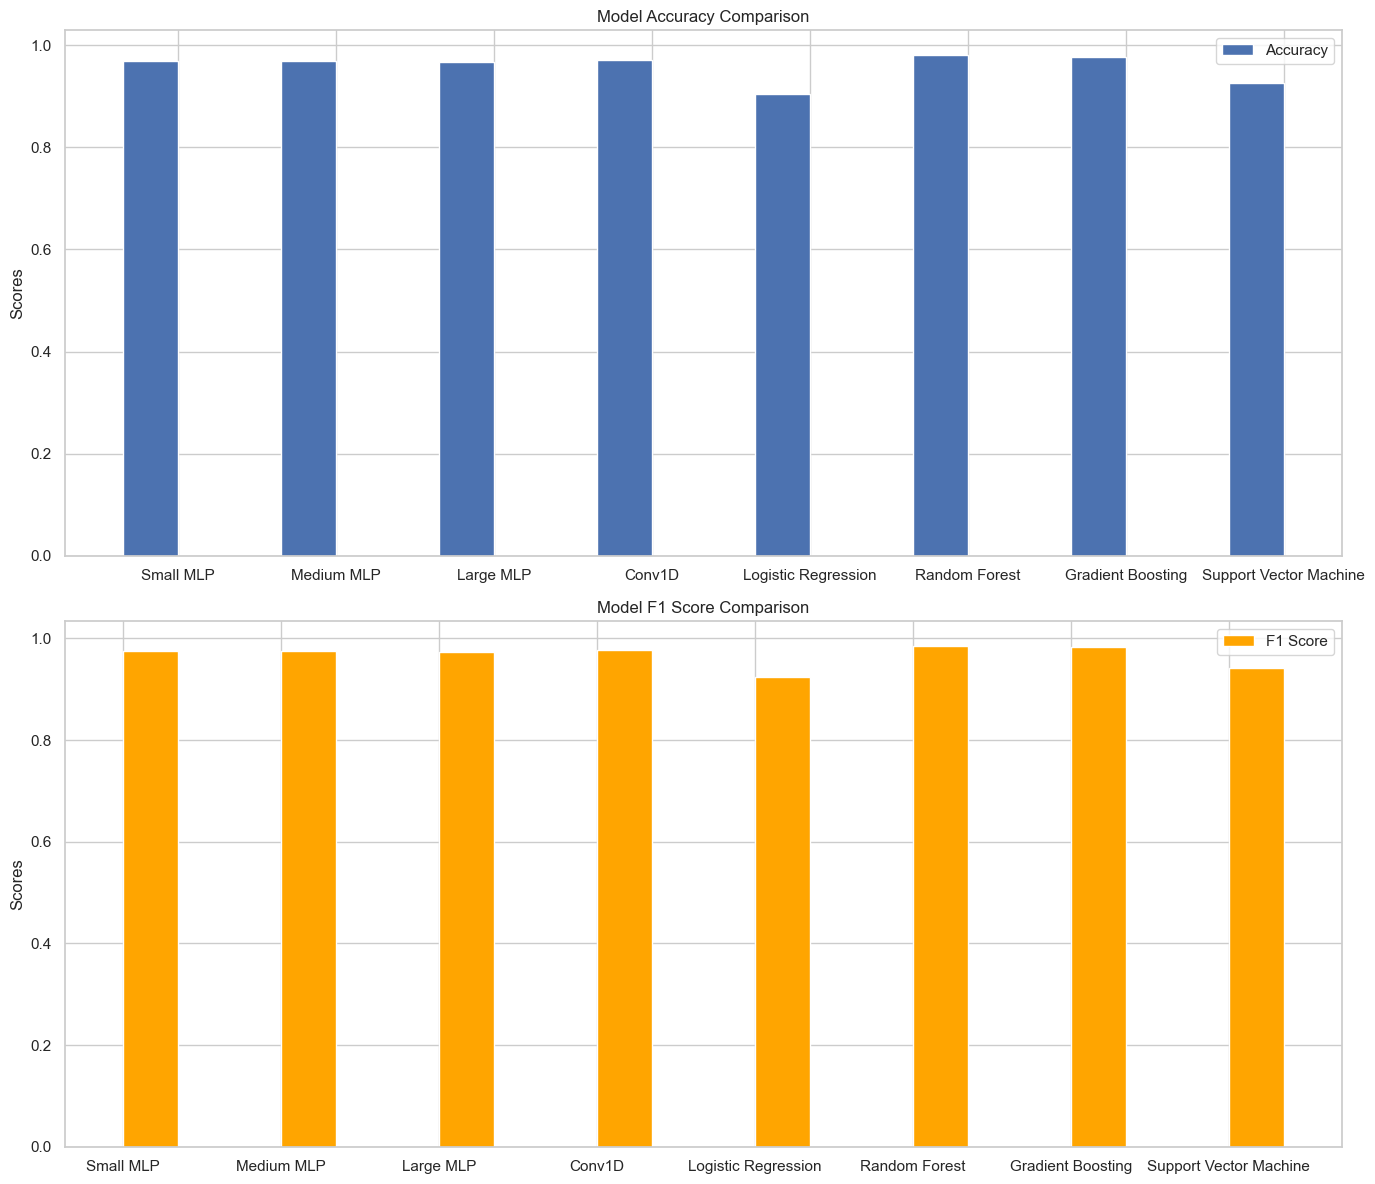

In [37]:
# compare
compare_torch_and_basic_models(torch_models_results, basic_models_results)

We can see all models get very good results.


Now let's change the features, as people are strategic, and see how the models
get worse in time. Then we will examine approaches to mitigate this fall in models performance (retraining, add bias to model output etc.)
